# Testing Algorithms for Paper

## Name: Victor Agaba

## Date: 2024-04-11

***

In [251]:
import numpy as np
from numpy import linalg
import functions as fn
import seismic_model as sm
import optimizer as opt
from matplotlib import pyplot as plt
from obspy.taup import TauPyModel
import importlib

***
#### Synthetic Parameters
***

Seed: 555
Original params:  [323.35388601  74.14648829 117.68550304]


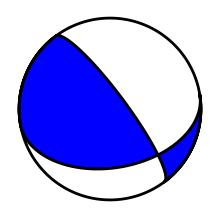

[45.74277419944782, 49.94361025435123]


In [ ]:
seed = np.random.randint(0, 2024)
np.random.seed(seed)
print(f'Seed: {seed}')

# np.random.seed(2024)
# np.random.seed(1513)
# np.random.seed(410)
# np.random.seed(560) # BUG plot_iterates_2D (off by 1)

# create random array for t, normalised to 1
t = fn.unit_vec(np.random.rand(3))

# create random array for p, normalised to 1
direc = fn.unit_vec(np.random.rand(3))
p = fn.starting_direc(t, direc)

# get truen params for synthetic test
true_params = fn.tp2sdr(t, p, True)[0]
print('Original params: ', true_params)

# plot corresponding beachball
beachball = fn.beachball(true_params)

# set up parameters for inversion
model = TauPyModel(model='ak135')  # velocity model
hdepth = 15  # km - assumed quake depth
epdist = 10  # degrees - epicentral distance
azimuth = 200  # degrees - azimuth of seismometer
arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['P', 'S'])
takeoff_angles = [a.takeoff_angle for a in arrivals]
print(takeoff_angles)
velocities = np.array([5.8000, 3.4600])

# NOTE: Be aware of more than one P/S arrival
# Plot beachball set: grid + ordered overlay
# Example events (Paula) --- Mars later
# Laplacians (finite differences)
# Moment tensor
# Alt cost function --- later

***
#### Hybrid Inversion
***

In [253]:
importlib.reload(fn)
importlib.reload(sm)
importlib.reload(opt)

# initialize model
inv_model = sm.SeismicModel(np.deg2rad(azimuth), takeoff_angles, velocities)
best_fit = inv_model(np.deg2rad(true_params), set_Ao=True)

# tune hyperparameters
config = opt.get_config()

# initialize random hybrid search: many runs
num_runs = 50
starts = fn.random_params(num_runs)

# # initialize systematic hybrid search: debugging
# step_size = 30
# starts = fn.systematic_params(step_size)
# num_runs = len(starts)

# multi-start optimization
inv_model.reset()
print_every = 10

for index, start in enumerate(starts):
    if print_every > 0 and index % print_every == 0:
        print(f'Run {index} of {num_runs}')
    opt.minimize(inv_model, config, start)
    
print(f'Convergence rate: {inv_model.convergence_rate():.0f}%')

Run 0 of 50
Run 10 of 50
Run 20 of 50
Run 30 of 50
Run 40 of 50
Convergence rate: 68%


Axis: T
Optimal parameters: [342.43372087  19.08256085  19.99319944]
Search error: 1.7322771451799766 degrees


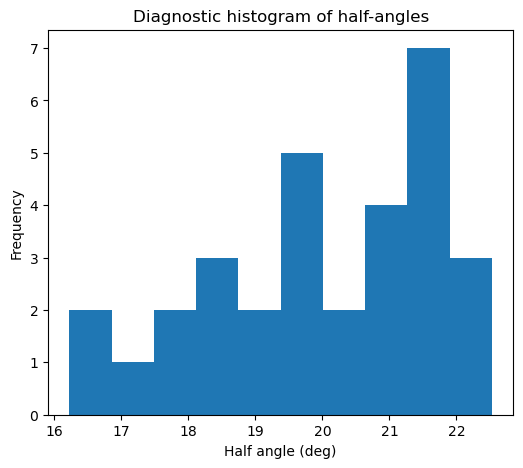

In [254]:
params, error, position = inv_model.optimal_parameterization()
name = 'T' if position == 0 else 'P'

print(f'Axis: {name}')
print(f'Optimal parameters: {np.rad2deg(params)}')
print(f'Search error: {np.rad2deg(error)} degrees')

inv_model.plot_half_angles(bins=10)

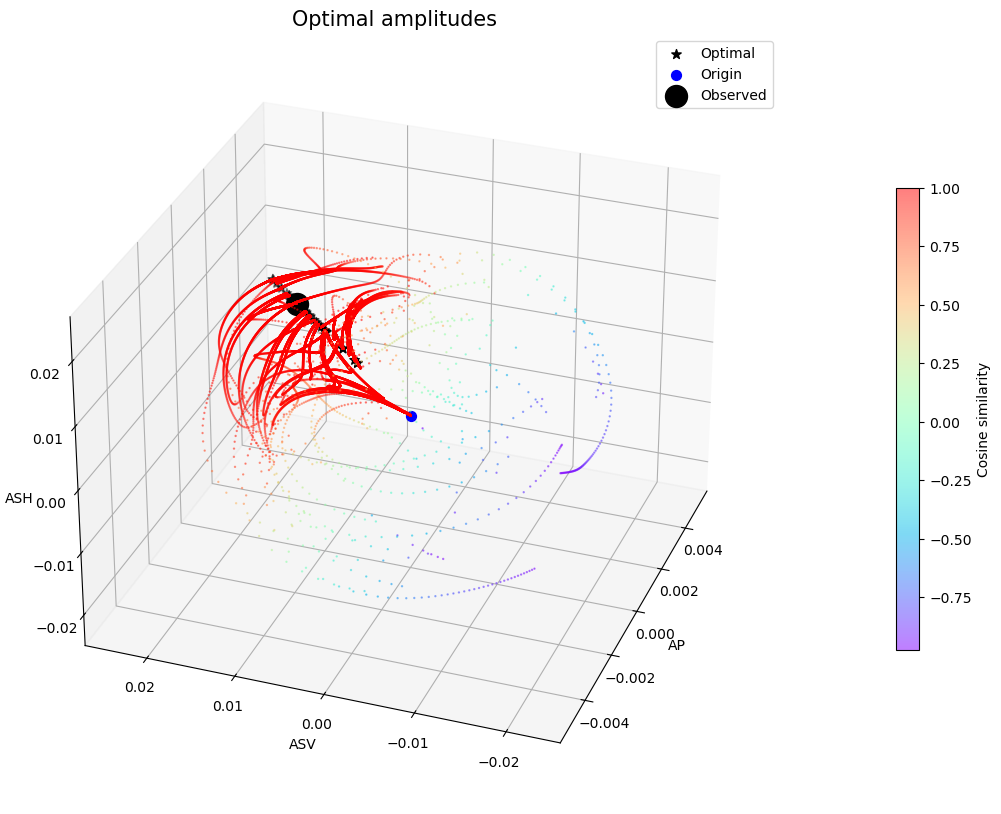

In [255]:
# amplitude plot
# TODO: include marker at origin
inv_model.plot_amplitudes(azim=200, elev=30, s=50, alpha=0.5, iterates=True)

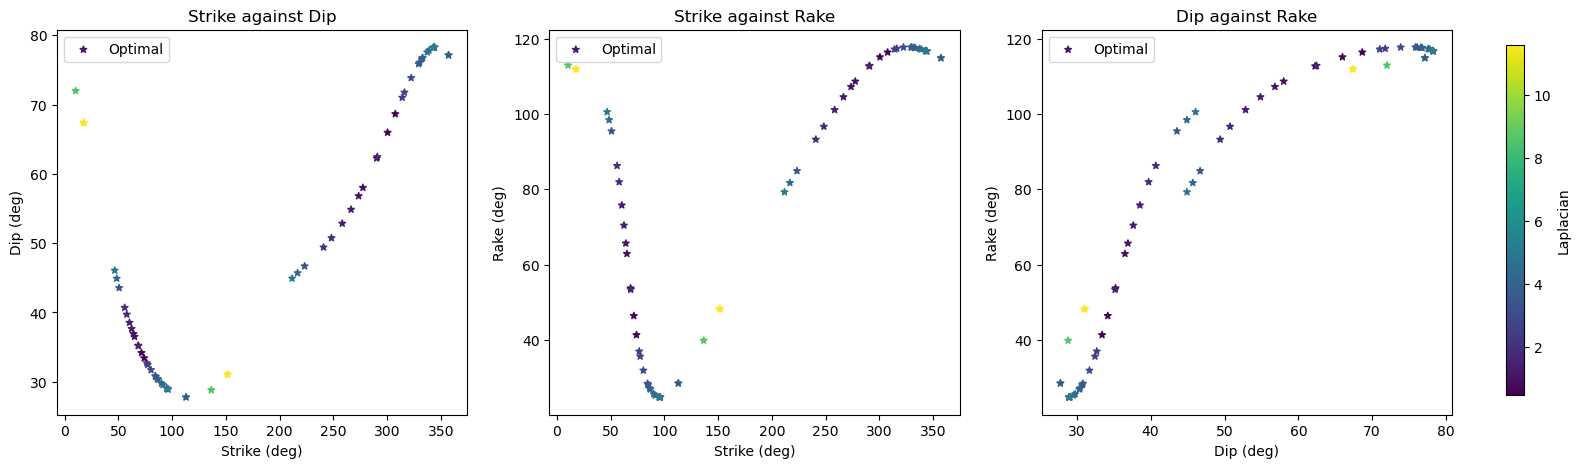

In [256]:
# iterate plot - sdr space
inv_model.plot_iterates_2D(s=25, optimal=True, index=2, cmap='viridis')
# inv_model.plot_iterates_2D(s=1, optimal=False, index=0)
# inv_model.plot_iterates_2D(s=1, optimal=False, index=1)

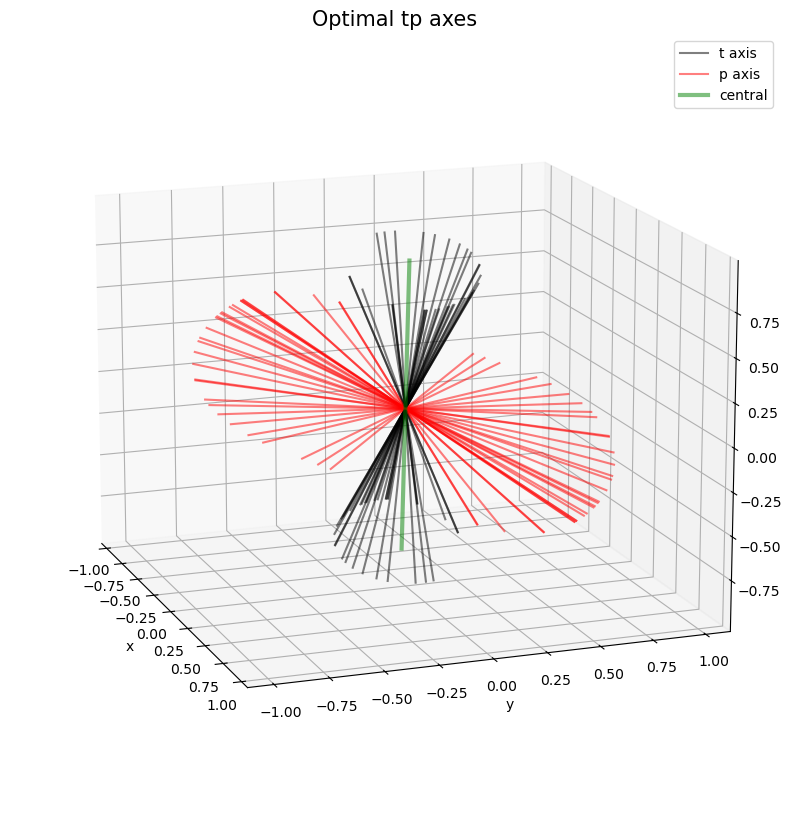

In [257]:
# optimal plot - tp space
inv_model.plot_tp_axes(azim=-20, elev=15, half=False)

In [258]:
laplacian_flow = np.rad2deg(inv_model.laplacian_flow())
print(f"Laplacian flow: {laplacian_flow}")

Laplacian flow: [  0.         -33.65359615   9.50400742]


***
#### Uncertainty Propagation
***

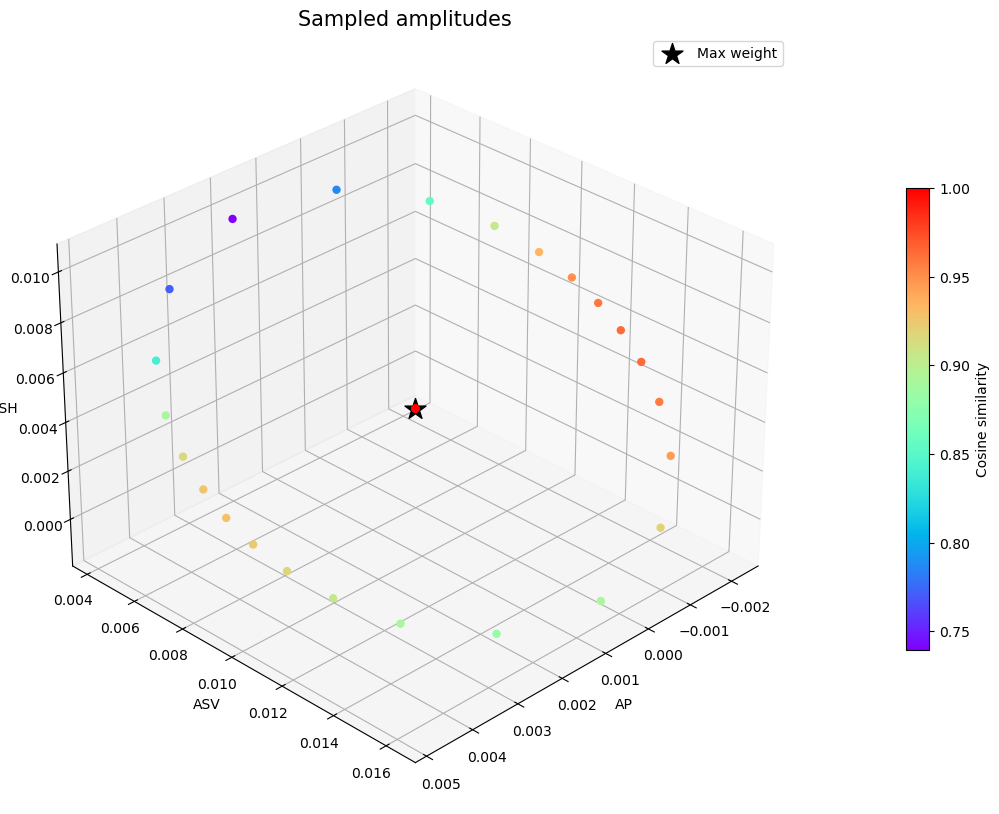

In [259]:
dd, num_samples = 15, 25
# dd, num_samples = 30, 15  # debugging
inv_model.init_uncertainty()
inv_model.sample_amplitudes(dd, num_samples)
inv_model.plot_sampled_amplitudes(cmap='rainbow', s=25)

In [260]:
num_runs, print_every = 30, 0
inv_model.monte_carlo(dd, num_samples, num_runs, print_every)

Sample 0 of 29


Sample 1 of 29
Sample 2 of 29
Sample 3 of 29
Sample 4 of 29
Sample 5 of 29
Sample 6 of 29
Sample 7 of 29
Sample 8 of 29
Sample 9 of 29
Sample 10 of 29
Sample 11 of 29
Sample 12 of 29
Sample 13 of 29
Sample 14 of 29
Sample 15 of 29
Sample 16 of 29
Sample 17 of 29
Sample 18 of 29
Sample 19 of 29
Sample 20 of 29
Sample 21 of 29
Sample 22 of 29
Sample 23 of 29
Sample 24 of 29
Sample 25 of 29
Sample 26 of 29
Sample 27 of 29
Sample 28 of 29


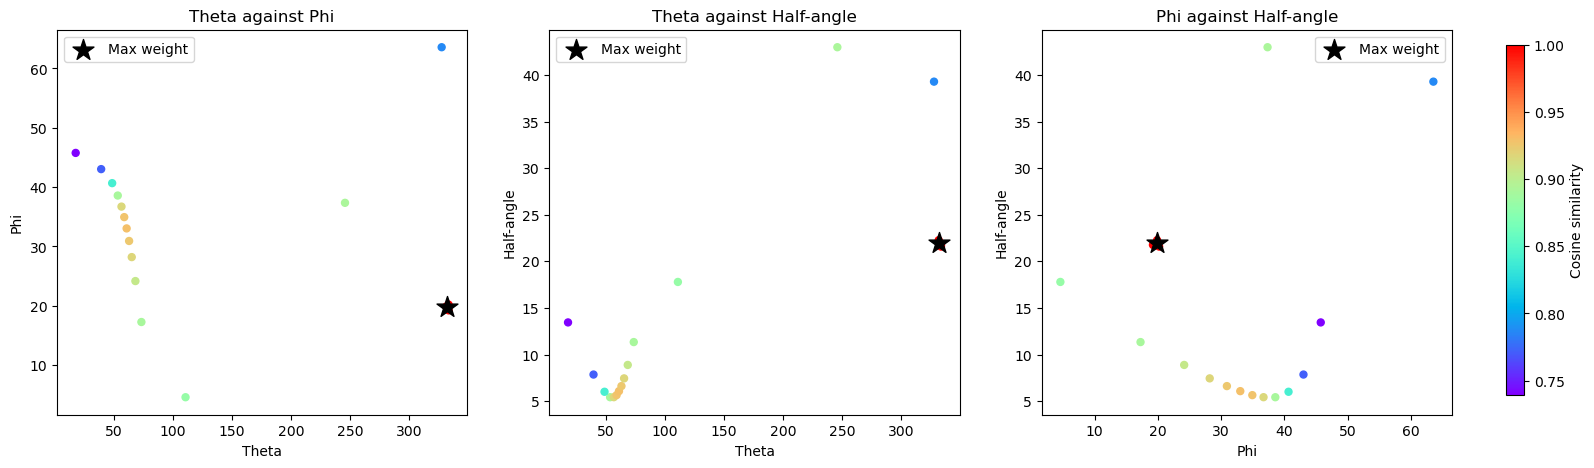

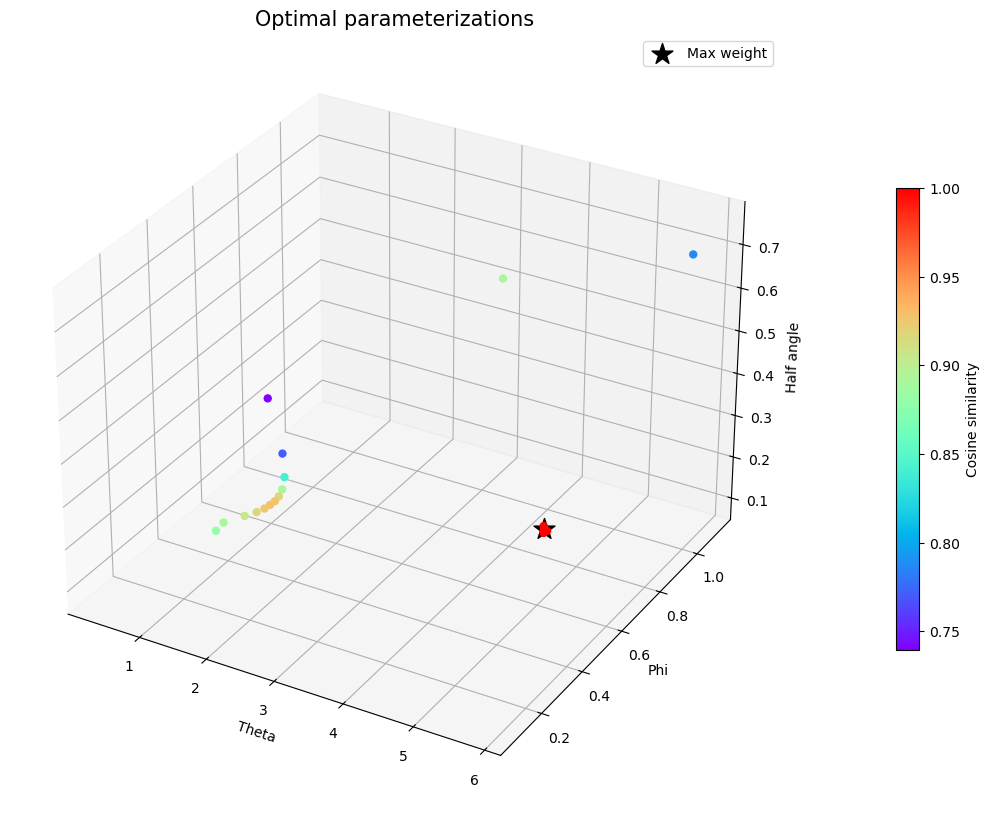

In [ ]:
# monte carlo plot - cone space
error_threshold = 5
inv_model.post_filter(threshold=error_threshold)
inv_model.plot_uncertainty_2D(s=25, scale=0)
# inv_model.plot_uncertainty_3D(elev=30, azim=45, s=25)

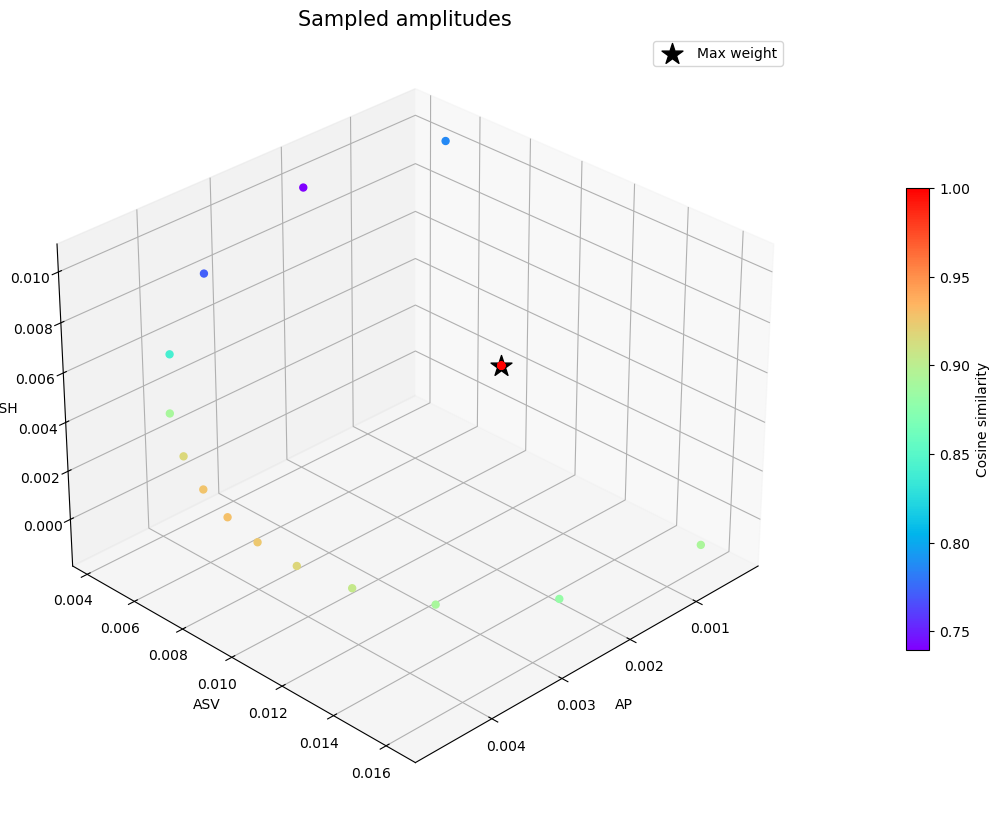

In [262]:
inv_model.plot_sampled_amplitudes(cmap='rainbow', s=25)

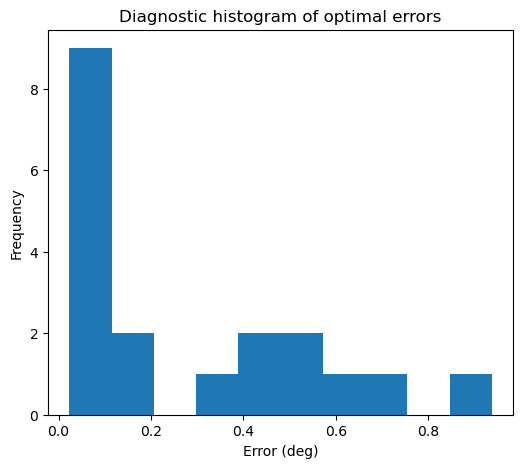

In [263]:
# diagnostic plot of monte carlo errors
inv_model.plot_optimal_errors(bins=10)